 ## C add attributes 2 and begin feat engineering
 Design matrix is one record per row


In [81]:
# formatting
import jupyter_black

jupyter_black.load(
    lab=False,
)

In [82]:
# imports

import pandas as pd
import numpy as np  # for np.nan
import os  # for path

import yfinance as yf

import json

from pandas_datareader.quandl import QuandlReader  # data side

reload_data = True
end_date = "2030-12-31"

In [83]:
with open("data/vars.json", "r") as json_file:
    var_dict = json.load(json_file)

In [84]:
# read in raw data
### INPUT ###

# formatted tradelog
trades_filename = "output/b_completewattr.csv"
df_raw = pd.read_csv(trades_filename)

### Existing Cols with Issues

In [85]:
existing_err_cols = [
    "AAII_SENT_Date",
    "AAII_SENT_Bullish",  ## AAII columns are missing later 2021 and 2022 values
    "AAII_SENT_Neutral",
    "AAII_SENT_Bearish",
    "AAII_SENT_Total",
    "AAII_SENT_Bullish8WeekMovAvg",
    "AAII_SENT_BullBearSpread",
    "AAII_SENT_BullishAverage",
    "AAII_SENT_BullishAverage+StDev",
    "AAII_SENT_BullishAverageStDev",
    "AAII_SENT_S&P500WeeklyHigh",
    "AAII_SENT_S&P500WeeklyLow",
    "AAII_SENT_S&P500WeeklyClose",
]

## pull data from yahoo finance

In [86]:
tickers = ["^VIX", "^GSPC"]
if reload_data:
    df_data = yf.download(
        " ".join(tickers), start="2010-01-01", end=end_date, group_by="Tickers"
    )
    # turn into tabular form
    df_data_formatted = (
        df_data.stack(level=0).reset_index().rename(columns={"level_1": "Ticker"})
    )
    df_data_formatted.to_csv("output/c_mktdata.csv")
else:
    df_data_formatted = pd.read_csv("output/c_mktdata.csv")

df_data_formatted.head()

[*********************100%***********************]  2 of 2 completed


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,^GSPC,1132.989990,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-04,^VIX,20.040001,20.040001,21.680000,20.030001,21.680000,0
2,2010-01-05,^GSPC,1136.520020,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
3,2010-01-05,^VIX,19.350000,19.350000,20.129999,19.340000,20.049999,0
4,2010-01-06,^GSPC,1137.140015,1137.140015,1139.189941,1133.949951,1135.709961,4972660000


In [87]:
# pivoted

df_data_pivot = df_data_formatted.pivot(
    index=["Date"],
    columns=["Ticker"],
    values=["Close"],
).reset_index()

# to deal with multiindex columns
df_data_pivot.columns = ["_".join(col).strip() for col in df_data_pivot.columns.values]
df_data_pivot.rename(columns={"Date_": "Date_YahooFinance"}, inplace=True)
df_data_pivot["Date_YahooFinance"] = pd.to_datetime(
    df_data_pivot["Date_YahooFinance"], errors="coerce"
)
df_data_pivot.head()

,Date_YahooFinance,Close_^GSPC,Close_^VIX
0,2010-01-04,1132.989990,20.040001
1,2010-01-05,1136.520020,19.350000
2,2010-01-06,1137.140015,19.160000
3,2010-01-07,1141.689941,19.059999
4,2010-01-08,1144.979980,18.129999


In [88]:
# merge

df_source = df_raw.copy(deep=True)

df_source["Open_Date"] = pd.to_datetime(df_source["Open_Date"], errors="coerce")


# need to sort
df_source = df_source.sort_values(["Open_Date"])
df_data_pivot = df_data_pivot.sort_values(["Date_YahooFinance"])

df_result = pd.merge_asof(
    df_source, df_data_pivot, left_on=["Open_Date"], right_on=["Date_YahooFinance"]
)

### Add Open Year

In [89]:
df_result["Open_Year"] = df_result["Open_Date"].dt.year

### Test data

In [90]:
df_result.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Open_Date', 'Close_Date', 'Symbol',
       'Quantity', 'Pnl', 'OpenAct', 'CloseAct', 'Open_Price', 'Close_Price',
       'Comm_Tot', 'DATE', 'ACTION', 'QTYCHG', 'PRICE', 'TIME', 'UNNAMED: 6',
       'COMMISSION', 'UNNAMED: 8', 'CASH CHG (PNL)', 'COMMENTS', 'PCTRETURN',
       'DETAILS', 'STARTDATE', 'COMPANY NAME (IN ALPHABETICAL ORDER)',
       'TICKER', 'STOP', '% TO STOP', 'CURRENT PRICE', '% TO TARGET',
       'AT PRICE', 'TARGET', 'EPS1', 'EPS2', 'FYEND', 'DAYSTOFYEND',
       'FYEPSNXT', 'GROWTH*0.5TO0.75', 'ROIC (BW ROA ROE)', 'TGT FWD P/E',
       'YEARS TO NORMALIZATION', 'LASTUPDATED', 'CATEGORY', 'COMMENTS.1',
       'FILENAME', 'DayOfWeek0Mon', 'Date_YahooFinance', 'Close_^GSPC',
       'Close_^VIX', 'Open_Year'],
      dtype='object')

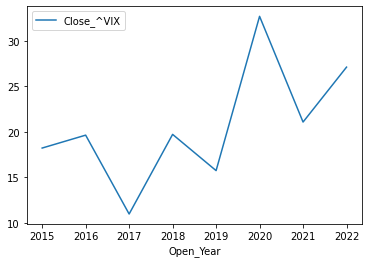

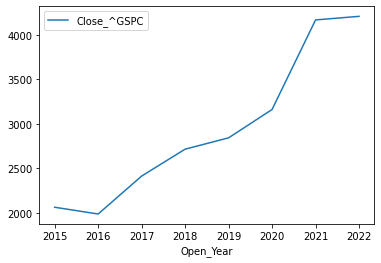

In [91]:
for symbol in tickers:
    temp_df = pd.pivot_table(
        df_result,
        index=["Open_Year"],
        values="Close_" + symbol,
        aggfunc="mean",
        dropna=False,
    )
    temp_df.plot()

    assert min(temp_df["Close_" + symbol]) > 0, "values should all be above zero"

## pull data from Quandl  / Nasdaq Data Link
1. log in is from [Nasdaq data link](https://docs.data.nasdaq.com/docs/python-installation)

In [92]:
externalvar_dict = {
    #     "AAII/AAII_SENTIMENT": "AAII_SENT",  ## aaii sentiment looks like it ends 4/2021
    "UMICH/SOC1": "CONS_SENT",  # consumer sentiment
    #     "FED/RIMLPAAAR_N_B": "FED_AAACORP",  ## daily Fed AAA rates #TODO ned to fix different timeframes
}

In [93]:
# for later
# import nasdaqdatalink

# NASDAQ_DATA_LINK_API_KEY = var_dict["NASDAQ_DATA_LINK_API_KEY"]
# data = nasdaqdatalink.get("AAII/AAII_SENTIMENT", start_date="2015-01-01", end_date="2030-12-31")

In [94]:
if reload_data:

    #     df_varlist = []

    for variable, value in externalvar_dict.items():

        quandl_key = var_dict["QUANDL_API"]

        QR = QuandlReader(variable, api_key=quandl_key, start="1/1/2015", end=end_date)

        QR_df = QR.read().reset_index()

        QR_df.columns = [
            value + "_" + str(col)  # if col.upper() != "DATE" else col
            for col in QR_df.columns
        ]

        #         df_varlist.append(QR_df)

        # merge Quandl
        QR_df_sorted = QR_df.sort_values([f"{value}_Date"])
        QR_df_sorted["Date"] = pd.to_datetime(QR_df[f"{value}_Date"], errors="coerce")

        # add iteratively
        df_result = pd.merge_asof(
            df_result,
            QR_df_sorted,
            left_on=["Open_Date"],
            right_on=[f"{value}_Date"],
            direction="backward", # can't see forward
        )

        #     QR_df = pd.concat(
        #         [df.set_index("Date") for df in df_varlist], axis=1, join="outer"
        #     ).reset_index()
        QR_df.to_csv(f"output/c_quandl_{value}.csv")
else:
    for variable, value in externalvar_dict.items():

        QR_df = pd.read_csv(f"output/c_quandl_{value}.csv")

        # merge Quandl
        QR_df_sorted = QR_df.sort_values(["Date"])
        QR_df_sorted["Date"] = pd.to_datetime(QR_df[f"{value}_Date"], errors="coerce")

        df_result = pd.merge_asof(
            df_result,
            QR_df_sorted,
            left_on=["Open_Date"],
            right_on=[f"{value}_Date"],
            direction="backward", # can't see forward
        )

In [95]:
df_result.head()

,Unnamed: 0.1,Unnamed: 0,Open_Date,Close_Date,Symbol,Quantity,Pnl,OpenAct,CloseAct,Open_Price,...,COMMENTS.1,FILENAME,DayOfWeek0Mon,Date_YahooFinance,Close_^GSPC,Close_^VIX,Open_Year,CONS_SENT_Date,CONS_SENT_Index,Date
0,0,0,2015-06-30,2016-01-07 11:12:44,AER,600.0,-4851.23,B,S,46.972120,...,NaN,PCM-Tracking - LogHist.csv,1.0,2015-06-30,2063.110107,18.23,2015,2015-06-30,96.1,2015-06-30
1,62,15,2015-06-30,2016-01-07 14:17:15,FMCC,3500.0,-2925.12,B,S,2.435028,...,NaN,PCM-Tracking - LogHist.csv,3.0,2015-06-30,2063.110107,18.23,2015,2015-06-30,96.1,2015-06-30
2,61,5,2015-06-30,2016-01-07 11:44:15,LYB,200.0,-2773.30,B,S,96.065000,...,NaN,NaN,NaN,2015-06-30,2063.110107,18.23,2015,2015-06-30,96.1,2015-06-30
3,60,657,2015-06-30,2016-08-18 11:16:45,AWH,200.0,-405.17,B,S,41.795663,...,NaN,PCM-Tracking - LogHist.csv,1.0,2015-06-30,2063.110107,18.23,2015,2015-06-30,96.1,2015-06-30
4,59,64,2015-06-30,2016-01-20 15:22:41,VALE,8000.0,6677.80,S,B,3.184507,...,NaN,PCM-Tracking - LogHist.csv,1.0,2015-06-30,2063.110107,18.23,2015,2015-06-30,96.1,2015-06-30


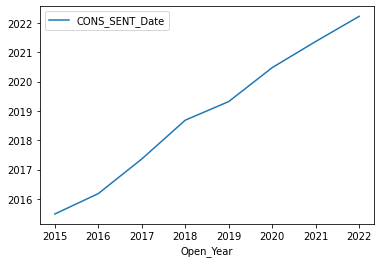

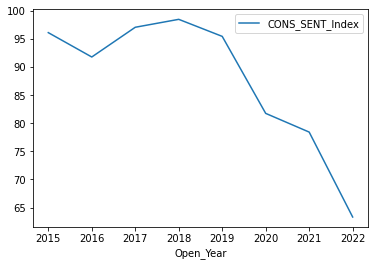

In [96]:
cols_with_errors = []

for variable, value in externalvar_dict.items():
    for c in df_result.columns:
        if value in c:
            temp_df = pd.pivot_table(
                df_result, index=["Open_Year"], values=c, aggfunc="mean", dropna=False
            )
            temp_df.plot()

            try:
                assert sum(temp_df[c].isna()) == 0, "values should all be filled"
            except:
                cols_with_errors.append(c)

In [97]:
cols_with_errors

[]

In [98]:
temp_df

,CONS_SENT_Index
Open_Year,
2015,96.100000
2016,91.770485
2017,97.055612
2018,98.464423
2019,95.435714
2020,81.748201
2021,78.424299
2022,63.329787


In [99]:
# check diff
assert len(set(cols_with_errors).difference(set(existing_err_cols))) == 0, "new errors"

## Pull AAII Sentiment Data
Source: https://www.aaii.com/sentimentsurvey/sent_results

In [100]:
df_aaii = pd.read_excel(f"data\sentiment.xls", header=[1, 2, 3])

In [101]:
df_aaii.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
              Reported           Reported           Reported   
                  Date            Bullish            Neutral   
0                  NaN                NaN                NaN   
1  1987-06-26 00:00:00                NaN                NaN   
2  1987-07-17 00:00:00                NaN                NaN   
3  1987-07-24 00:00:00               0.36               0.50   
4  1987-07-31 00:00:00               0.26               0.48   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Bullish                                \
            Reported           Reported  8-week Bull-Bear   Bullish   Average   
             Bearish              Total Mov Avg    Spread   Average +St. Dev.   
0                NaN                NaN     NaN       NaN       NaN       NaN   
1                NaN                NaN     NaN       NaN  0.377495  0.478443   
2                NaN                NaN     NaN       NaN  0.377495  0.478443   
3               0.14                1.0     NaN      0.22  0.377495  0.478443   
4               0.26                1.0     NaN      0.00  0.377495  0.478443   

             S&P 500                  
              Weekly                  
  - St. Dev.    High     Low   Close  
0        NaN     NaN     NaN     NaN  
1   0.276547     NaN     NaN     NaN  
2   0.276547  314.59  307.63  314.59  
3   0.276547  311.39  307.81  309.27  
4   0.276547  318.66  310.65  318.66

In [102]:
df_aaii.tail()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
               Reported           Reported           Reported   
                   Date            Bullish            Neutral   
2023          Count '17               52.0               52.0   
2024          Count '18               52.0               52.0   
2025          Count '19               52.0               52.0   
2026          Count '20               53.0               53.0   
2027          Count '21               51.0               51.0   

     Unnamed: 3_level_0 Unnamed: 4_level_0 Bullish                    \
               Reported           Reported  8-week Bull-Bear Bullish   
                Bearish              Total Mov Avg    Spread Average   
2023               52.0                NaN    52.0      52.0     NaN   
2024               52.0                NaN    52.0      52.0     NaN   
2025               52.0                NaN    52.0      52.0     NaN   
2026               53.0                NaN    53.0      53.0     NaN   
2027               51.0                NaN    51.0      51.0     NaN   

                          S&P 500              
       Average             Weekly              
     +St. Dev. - St. Dev.    High   Low Close  
2023       NaN        NaN    52.0  52.0  52.0  
2024       NaN        NaN    52.0  52.0  52.0  
2025       NaN        NaN    52.0  52.0  52.0  
2026       NaN        NaN    53.0  53.0  53.0  
2027       NaN        NaN    51.0  51.0  51.0

In [103]:
# squeeze multilevel columns to one
col_list = list(df_aaii.columns.map("_".join))
col_list = [s.replace("Unnamed: ", "") for s in col_list]
col_list

['0_level_0_Reported_Date',
 '1_level_0_Reported_Bullish',
 '2_level_0_Reported_Neutral',
 '3_level_0_Reported_Bearish',
 '4_level_0_Reported_Total',
 'Bullish_8-week_Mov Avg',
 'Bullish_Bull-Bear_Spread',
 'Bullish_Bullish_Average',
 'Bullish_Average_+St. Dev.',
 'Bullish_Average_- St. Dev.',
 'S&P 500_Weekly_High',
 'S&P 500_Weekly_Low',
 'S&P 500_Weekly_Close']

In [104]:
df_aaii.columns = col_list
df_aaii.columns

Index(['0_level_0_Reported_Date', '1_level_0_Reported_Bullish',
       '2_level_0_Reported_Neutral', '3_level_0_Reported_Bearish',
       '4_level_0_Reported_Total', 'Bullish_8-week_Mov Avg',
       'Bullish_Bull-Bear_Spread', 'Bullish_Bullish_Average',
       'Bullish_Average_+St. Dev.', 'Bullish_Average_- St. Dev.',
       'S&P 500_Weekly_High', 'S&P 500_Weekly_Low', 'S&P 500_Weekly_Close'],
      dtype='object')

In [105]:
# save only those with dates
saved_idx = ~pd.to_datetime(df_aaii["0_level_0_Reported_Date"], errors="coerce").isna()

In [106]:
# final usable
df_aaii = df_aaii.loc[saved_idx]
df_aaii["Date"] = pd.to_datetime(df_aaii["0_level_0_Reported_Date"])
df_aaii.head()

,0_level_0_Reported_Date,1_level_0_Reported_Bullish,2_level_0_Reported_Neutral,3_level_0_Reported_Bearish,4_level_0_Reported_Total,Bullish_8-week_Mov Avg,Bullish_Bull-Bear_Spread,Bullish_Bullish_Average,Bullish_Average_+St. Dev.,Bullish_Average_- St. Dev.,S&P 500_Weekly_High,S&P 500_Weekly_Low,S&P 500_Weekly_Close,Date
1,1987-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.377495,0.478443,0.276547,NaN,NaN,NaN,1987-06-26
2,1987-07-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.377495,0.478443,0.276547,314.59,307.63,314.59,1987-07-17
3,1987-07-24 00:00:00,0.36,0.50,0.14,1.0,NaN,0.22,0.377495,0.478443,0.276547,311.39,307.81,309.27,1987-07-24
4,1987-07-31 00:00:00,0.26,0.48,0.26,1.0,NaN,0.00,0.377495,0.478443,0.276547,318.66,310.65,318.66,1987-07-31
5,1987-08-07 00:00:00,0.56,0.15,0.29,1.0,NaN,0.27,0.377495,0.478443,0.276547,323.00,316.23,323.00,1987-08-07


In [107]:
df_aaii_sorted.head()

,AAII_0_level_0_Reported_Date,AAII_1_level_0_Reported_Bullish,AAII_2_level_0_Reported_Neutral,AAII_3_level_0_Reported_Bearish,AAII_4_level_0_Reported_Total,AAII_Bullish_8-week_Mov Avg,AAII_Bullish_Bull-Bear_Spread,AAII_Bullish_Bullish_Average,AAII_Bullish_Average_+St. Dev.,AAII_Bullish_Average_- St. Dev.,AAII_S&P 500_Weekly_High,AAII_S&P 500_Weekly_Low,AAII_S&P 500_Weekly_Close,AAII_Date
1,1987-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.377495,0.478443,0.276547,NaN,NaN,NaN,1987-06-26
2,1987-07-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.377495,0.478443,0.276547,314.59,307.63,314.59,1987-07-17
3,1987-07-24 00:00:00,0.36,0.50,0.14,1.0,NaN,0.22,0.377495,0.478443,0.276547,311.39,307.81,309.27,1987-07-24
4,1987-07-31 00:00:00,0.26,0.48,0.26,1.0,NaN,0.00,0.377495,0.478443,0.276547,318.66,310.65,318.66,1987-07-31
5,1987-08-07 00:00:00,0.56,0.15,0.29,1.0,NaN,0.27,0.377495,0.478443,0.276547,323.00,316.23,323.00,1987-08-07


In [108]:
df_aaii_sorted = df_aaii.sort_values(["0_level_0_Reported_Date"])
df_aaii_sorted.columns = ["AAII_" + c for c in df_aaii_sorted.columns]
df_result = pd.merge_asof(
    df_result,
    df_aaii_sorted,
    left_on=["Open_Date"],
    right_on=[f"AAII_Date"],
    direction="backward",
)
df_result.head()

,Unnamed: 0.1,Unnamed: 0,Open_Date,Close_Date,Symbol,Quantity,Pnl,OpenAct,CloseAct,Open_Price,...,AAII_4_level_0_Reported_Total,AAII_Bullish_8-week_Mov Avg,AAII_Bullish_Bull-Bear_Spread,AAII_Bullish_Bullish_Average,AAII_Bullish_Average_+St. Dev.,AAII_Bullish_Average_- St. Dev.,AAII_S&P 500_Weekly_High,AAII_S&P 500_Weekly_Low,AAII_S&P 500_Weekly_Close,AAII_Date
0,0,0,2015-06-30,2016-01-07 11:12:44,AER,600.0,-4851.23,B,S,46.972120,...,1.000001,0.267945,0.138889,0.377495,0.478443,0.276547,2129.87,2082.1,2108.58,2015-06-25
1,62,15,2015-06-30,2016-01-07 14:17:15,FMCC,3500.0,-2925.12,B,S,2.435028,...,1.000001,0.267945,0.138889,0.377495,0.478443,0.276547,2129.87,2082.1,2108.58,2015-06-25
2,61,5,2015-06-30,2016-01-07 11:44:15,LYB,200.0,-2773.30,B,S,96.065000,...,1.000001,0.267945,0.138889,0.377495,0.478443,0.276547,2129.87,2082.1,2108.58,2015-06-25
3,60,657,2015-06-30,2016-08-18 11:16:45,AWH,200.0,-405.17,B,S,41.795663,...,1.000001,0.267945,0.138889,0.377495,0.478443,0.276547,2129.87,2082.1,2108.58,2015-06-25
4,59,64,2015-06-30,2016-01-20 15:22:41,VALE,8000.0,6677.80,S,B,3.184507,...,1.000001,0.267945,0.138889,0.377495,0.478443,0.276547,2129.87,2082.1,2108.58,2015-06-25


## Final Checks

In [109]:
df_result.loc[0, df_result.columns.duplicated()]

Series([], Name: 0, dtype: object)

In [110]:
assert len(df_result.loc[0, df_result.columns.duplicated()]) == 0, "duplicates"

## Save Output

In [111]:
df_result.to_csv("output/c_resulttradewattr.csv")